In [9]:
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [4]:
# Quarterly data: 72-period test set, 8 variables

arfit_all = pyreadr.read_r('../SVol Benchmarks/arfit_all_quarterly.RData')['arfit_all'].to_numpy().T
svfit_all = pyreadr.read_r('../SVol Benchmarks/svfit_all_quarterly.RData')['svfit_all'].to_numpy().T
Y = pd.read_csv('../SVol Benchmarks/quarterlyData_updated.csv')
Y = Y.drop(columns=['Unnamed: 0', 'Date'])
# Subset to only test set
Y = Y.iloc[-70:, :]
var_names = list(Y.columns)

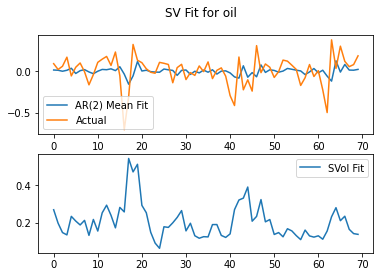

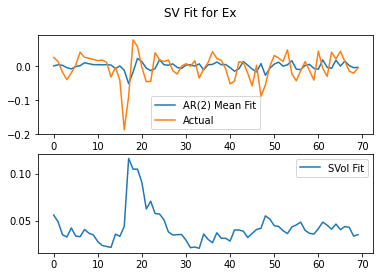

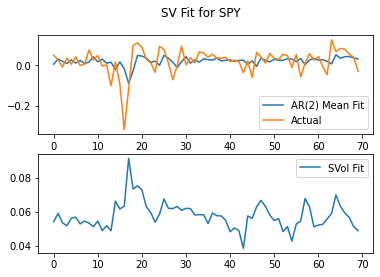

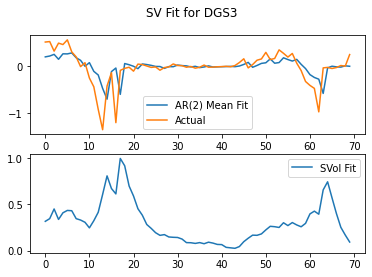

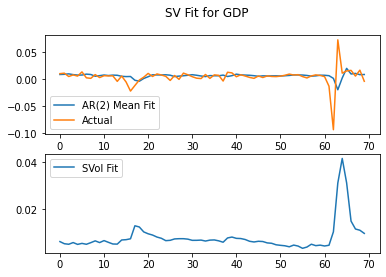

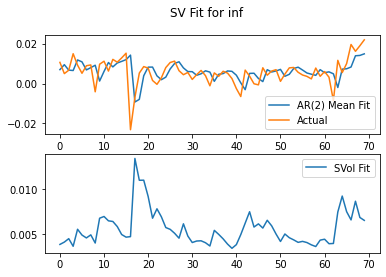

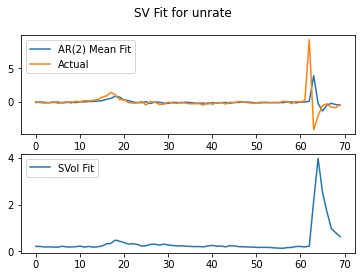

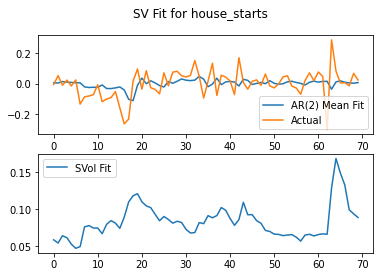

In [5]:
# Plot y and the predicted mean in a graph
for var_num in range(Y.shape[1]):
    y = Y.iloc[:,var_num].to_numpy()
    ar = arfit_all[:,var_num]
    sv = svfit_all[:, var_num]
    
    # Create a 2x1 subplot, plotting arfit_all and y in the first plot, and svfit_all in the second plot
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('SV Fit for ' + Y.columns[var_num])
    ax1.plot(ar, label='AR(2) Mean Fit')
    ax1.plot(y, label='Actual')
    ax1.legend()
    ax2.plot(sv, label='SVol Fit')
    ax2.legend()
    plt.show()

### Getting Predictive Density Scores

In [6]:
# Mean across all bootstraps: all are same size (n_obs x n_vars)
# Remove COVID (last 8 obs)
covid_to_remove = 8

preds_test_mean = arfit_all[:-covid_to_remove, :]
sigmas_mean = svfit_all[:-covid_to_remove, :]
Y_test = Y.to_numpy()[:-covid_to_remove, :]

In [10]:
PRED_DENSITY_MARG_ALL = np.zeros((1, preds_test_mean.shape[0], preds_test_mean.shape[1]))
PRED_DENSITY_MARG_ALL[:] = np.nan
# Loop over all time steps
for t in range(preds_test_mean.shape[0]):
  pred_mean = preds_test_mean[t, :]
  pred_sigma = sigmas_mean[t, :]
  y_test = Y_test[t, :]
  
  for var in range(preds_test_mean.shape[1]):
    # Construct a univariate normal with pred_mean and pred_sigma
    univ_norm = multivariate_normal(pred_mean[var], pred_sigma[var])
    # Evaluate density at y_test
    log_density = univ_norm.logpdf(y_test[var])
    PRED_DENSITY_MARG_ALL[0, t, var] = log_density
  

In [22]:
# Make dataframe wtih sum and mean of predictive density as the 2 columns
marginal_density_df = pd.DataFrame()
for var in range(preds_test_mean.shape[1]):
  marginal_density_df_var = pd.DataFrame({'Mean': PRED_DENSITY_MARG_ALL[:, :, var].mean(axis=1),
                        'Median': np.median(PRED_DENSITY_MARG_ALL[:, :, var], axis=1),
                        '10th': np.percentile(PRED_DENSITY_MARG_ALL[:, :, var], 10, axis=1),
                        '90th': np.percentile(PRED_DENSITY_MARG_ALL[:, :, var], 90, axis=1),
                        'Variable': var_names[var]
                        })
  
  marginal_density_df = pd.concat([marginal_density_df, marginal_density_df_var], axis=0).reset_index(drop=True)

In [23]:
marginal_density_df

,Mean,Median,10th,90th,Variable
0,-0.143246,-0.107028,-0.480253,0.100061,oil
1,0.679275,0.711194,0.458870,0.873984,Ex
2,0.482119,0.503957,0.412358,0.573348,SPY
3,-0.227864,-0.283074,-0.738893,0.372710,DGS3
4,1.643602,1.632594,1.501167,1.816681,GDP
5,1.707110,1.733874,1.562113,1.854417,inf
6,-0.258367,-0.198314,-0.460942,-0.069155,unrate
7,0.327223,0.331598,0.177137,0.461097,house_starts


Text(0, 0.5, 'Log Density')

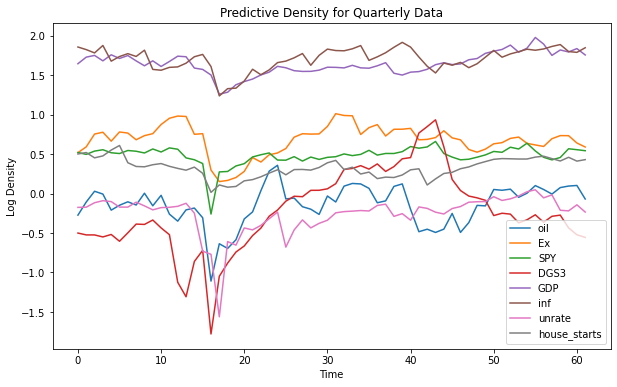

In [29]:
# Plot the log density for each variable
plt.figure( figsize=(10, 6))
for var_num in range(Y.shape[1]):
  plt.plot(PRED_DENSITY_MARG_ALL[0, :, var_num], label=Y.columns[var_num])
  # Set legend 
  plt.legend()

# Set title of plot
plt.title('Predictive Density for Quarterly Data')
# Set x-axis label
plt.xlabel('Time')
# Set y-axis label
plt.ylabel('Log Density')